In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scsp
import scipy.integrate as scint
import sys
sys.path.insert(0, '/users/milan/nudetect')
import nudetect

In [2]:
CIT2921 = nudetect.Source("Am241", 2921)

In [3]:
h119_Am241 = nudetect.GammaFlood("floodAm241_5C_-500V_20190725_capoffset_corrected.fits",
                                 detector="H119",
                                 source = CIT2921,
                                 voltage = 500,
                                 temp=5,
                                 data_dir='Am241_capoffset/data',
                                 plot_dir='Am241_capoffset/plots'
                                )

In [4]:
%%time
h119_Am241.load_raw_data()

CPU times: user 28.9 s, sys: 2min 39s, total: 3min 8s
Wall time: 2min 11s


In [5]:
%%time
h119_Am241.gen_count_map(mask_sigma_above=2, mask_sigma_below=3)

CPU times: user 2h 48min 22s, sys: 1h 32min 46s, total: 4h 21min 9s
Wall time: 1h 18min 12s


masked_array(
  data=[[19204, 7019, 10302, ..., 16307, 10864, 16551],
        [8647, 6764, 7604, ..., 15090, 8828, 10179],
        [9602, 6888, 8481, ..., 14781, 10240, 11517],
        ...,
        [9440, --, --, ..., --, --, --],
        [10636, 6609, --, ..., --, --, --],
        [13913, 10387, 11565, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False,  True,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint32)

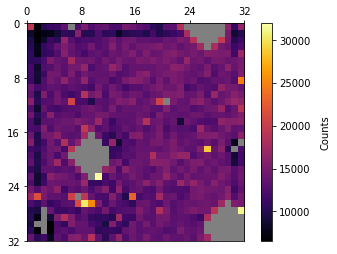

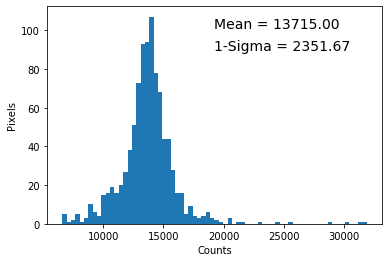

In [6]:
h119_Am241.plot_pixel_map('Count')
h119_Am241.plot_pixel_hist('Count')

In [7]:
time_data, _ = nudetect.fits_to_df("floodAm241_5C_-500V_20190725.e.corrected.fits",
                                   ["RESET", "TIME", "GRADE"],
                                   pos=0)

cluster_1 = [(0,4), (0,5), (0,7), (0,8), (1,5), (1,6), (1,7), (2,6)]

mask = 0

for i, j in cluster_1:
    mask |= (h119_Am241.raw_data_1d['RAWX'] == i) & (h119_Am241.raw_data_1d['RAWY'] == j)

mask &= (time_data["RESET"] < (200*14.7456))

low_count_pixs = [(14, 25), (12, 14), (9, 11), (6, 15)]

for i, j in low_count_pixs:
    mask |= (h119_Am241.raw_data_1d['RAWX'] == i) & (h119_Am241.raw_data_1d['RAWY'] == j)

In [8]:
tp_mask = (h119_Am241.raw_data_1d['STIM'] == 1)

In [9]:
grade_mask = (time_data["GRADE"] == 0)

In [10]:
%%time
h119_Am241.gen_quick_gain(plot_subdir='gamma_pix', misc_mask=~(tp_mask | mask) & grade_mask)

/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4018: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
/users/milan/nudetect/nudetect.py:4

ValueError: `bins` must increase monotonically, when an array

ValueError: Image size of 2009111x302 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [11]:
h119_Am241.plot_pixel_map('Gain')

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [ ]:
%%time
h119_Am241.gen_spectrum(misc_mask=~(tp_mask | mask) & grade_mask)

In [ ]:
h119_Am241.plot_spectrum(fit_below=50, fit_above=60)

In [12]:
((h119_Am241.raw_data_1d['RAWX'] == 0) & (h119_Am241.raw_data_1d['RAWY'] == 5)).values.sum()

34880

In [547]:
low_count_pixs = [(14, 25), (12, 14), (9, 11), (6, 15)]

for i, j in low_count_pixs:    
    print(((h119_Am241.raw_data_1d['RAWX'] == i) & (h119_Am241.raw_data_1d['RAWY'] == j) & (h119_Am241.raw_data_1d['PH'] > 0)).values.sum())

850
410
906
4181


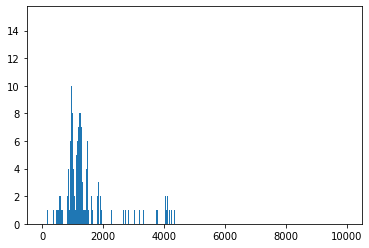

In [549]:
# Getting pulse height in channels for all events for the 
# current pixel. We store this in 'channel' as a numpy.ndarray,
# since we don't need the index of the original DataFrame, and
# np.histogram should be faster on an ndarray than a DataFrame.
channel = h119_Am241.raw_data_1d.loc[
    (h119_Am241.raw_data_1d['RAWX'] == 6) & (h119_Am241.raw_data_1d['RAWY'] == 15) , 'PH'].values

# If there were events at this pixel, fit the strongest peak
# in the channel spectrum with a Gaussian.
if len(channel):
    # 'spectrum' contains counts at each channel
    spectrum, edges = np.histogram(channel, bins=np.arange(1, 10000), 
            range=(0, 10000))
    plt.hist(channel, bins=np.arange(1,10000))

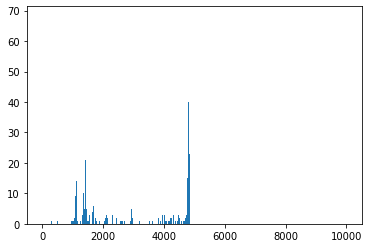

In [33]:
# Getting pulse height in channels for all events for the 
# current pixel. We store this in 'channel' as a numpy.ndarray,
# since we don't need the index of the original DataFrame, and
# np.histogram should be faster on an ndarray than a DataFrame.
channel = h119_Am241.raw_data_1d.loc[
    (h119_Am241.raw_data_1d['RAWX'] == 16) & (h119_Am241.raw_data_1d['RAWY'] == 5) & grade_mask, 'PH'].values

# If there were events at this pixel, fit the strongest peak
# in the channel spectrum with a Gaussian.
if len(channel):
    # 'spectrum' contains counts at each channel
    spectrum, edges = np.histogram(channel, bins=np.arange(1, 10000), 
            range=(0, 10000))
    plt.hist(channel, bins=np.arange(1,10000))

/disk/lif2/milan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


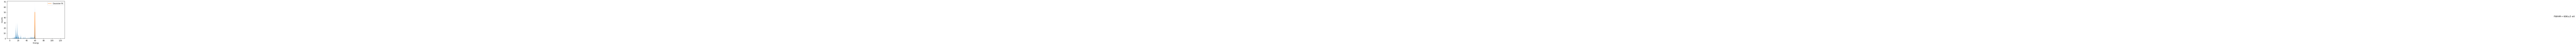

In [45]:
centroid = np.argmax(spectrum[4000:6000]) + 4000
                    # Excluding funky tails for the fitting process.
energy=59.5
maxchannel=10000
bins=np.arange(1,10000)
fit_channels = np.arange(
                        centroid - 100, centroid + 200)
g_init = models.Gaussian1D(amplitude=spectrum[centroid], 
                        mean=centroid, stddev=75)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, fit_channels, spectrum[fit_channels])
gain=energy/g.mean
plt.figure()

sigma_err = np.diag(fit_g.fit_info['param_cov'])[2]
fwhm_err = 2 * np.sqrt(2 * np.log(2)) * sigma_err
mean_err = np.diag(fit_g.fit_info['param_cov'])[1]
frac_err = np.sqrt(np.square(fwhm_err) + np.square(g.fwhm * mean_err / g.mean))\
                            / g.mean
str_err = str(int(round(frac_err * energy * 1000)))
str_fwhm = str(int(round(energy * 1000 * g.fwhm / g.mean, 0)))
plt.text(maxchannel * 3 / 5, spectrum[centroid] * 3 / 5,
                                r'$\mathrm{FWHM}=$' + str_fwhm + r'$\pm$' + str_err + ' eV', fontsize=13)

plt.hist(np.multiply(channel, gain), 
                                bins=np.multiply(bins, gain),
                                range=(0, maxchannel * gain), 
                                histtype='stepfilled')

plt.plot(
                                fit_channels * gain, 
                                g(fit_channels), label='Gaussian fit')

plt.ylabel('Counts')
plt.xlabel('Energy')
plt.legend()
plt.tight_layout()

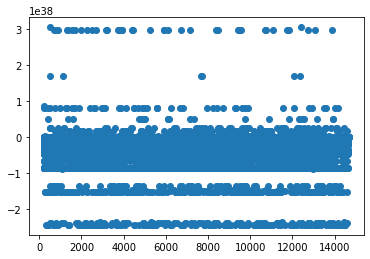

In [24]:
plt.scatter(time_data['RESET'], h119_Am241.raw_data_1d['PH'])

/users/milan/nudetect/nudetect.py:4138: RuntimeWarning: invalid value encountered in greater
  del energies
/disk/lif2/milan/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/disk/lif2/milan/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


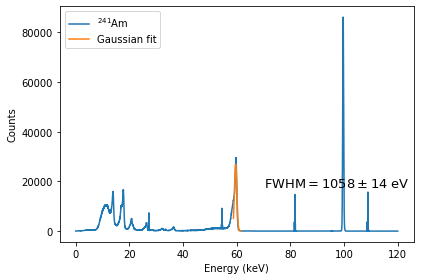

In [37]:
# no mask
h119_Am241.gen_quick_gain(save_plot=False, save_data=False)
h119_Am241.gen_spectrum(save_data=False)
h119_Am241.plot_spectrum(save_plot=False)

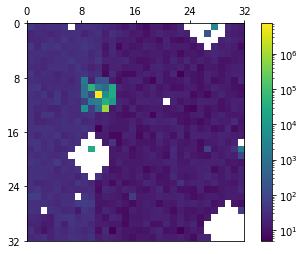

In [35]:
H, xedges, yedges = np.histogram2d(h119_Am241.raw_data_1d['RAWX'].loc[tp_mask],h119_Am241.raw_data_1d['RAWY'].loc[tp_mask],
           bins=32, range=[[0, 31], [0, 31]])

plt.imshow(H.T, norm=LogNorm(), extent=(0,32,32,0))
plt.gca().xaxis.tick_top()
plt.yticks(np.arange(0, 36, 8))
plt.xticks(np.arange(0, 36, 8))
plt.colorbar()

In [24]:
from matplotlib.colors import LogNorm

In [49]:
sq_mask = ((h119_Am241.raw_data_1d['RAWX'] - 8).abs() > 4) | ((h119_Am241.raw_data_1d['RAWY'] - 8).abs() > 4)

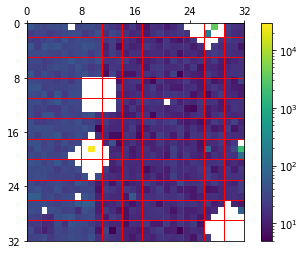

In [50]:
H, xedges, yedges = np.histogram2d(h119_Am241.raw_data_1d['RAWX'].loc[tp_mask & sq_mask],
                                   h119_Am241.raw_data_1d['RAWY'].loc[tp_mask & sq_mask],
           bins=32, range=[[0, 31], [0, 31]])

plt.imshow(H.T, norm=LogNorm(), extent=(0,32,32,0))
plt.gca().xaxis.tick_top()
plt.yticks(np.arange(0, 36, 8))
plt.xticks(np.arange(0, 36, 8))
for i in range(10):
    plt.axvline(2 + i * 3, color='red', lw=1)
    plt.axhline(2 + i * 3, color='red', lw=1)
plt.colorbar()

In [488]:
%%time
h119_Am241.gen_spectrum(save_data=False, misc_mask=tp_mask & ~sq_mask & ~pixel_mask(10, 10))
#square_tp_spec = h119_Am241.spectrum
square_tp_spec_no_10_10 = h119_Am241.spectrum

CPU times: user 3h 12min 17s, sys: 16min 2s, total: 3h 28min 19s
Wall time: 45min 35s


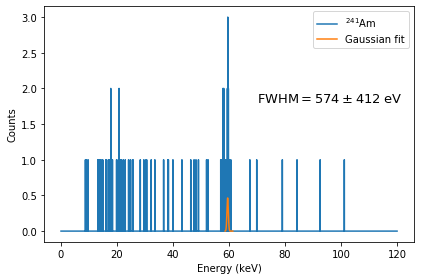

In [489]:
h119_Am241.plot_spectrum(save_plot=False)

CPU times: user 3h 19min 4s, sys: 17min 9s, total: 3h 36min 14s
Wall time: 51min 26s


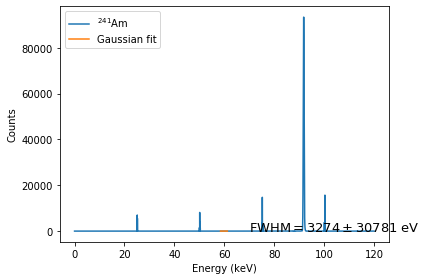

In [493]:
%%time
h119_Am241.gen_spectrum(save_data=False, misc_mask=tp_mask & pixel_mask(10, 10))
#square_tp_spec = h119_Am241.spectrum
spec_tp_only_10_10 = h119_Am241.spectrum
h119_Am241.plot_spectrum(save_plot=False)

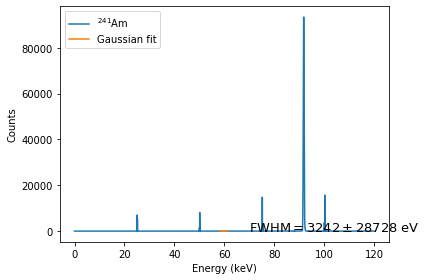

In [482]:
h119_Am241.plot_spectrum(save_plot=False)

In [85]:
%%time
h119_Am241.gen_spectrum(save_data=False, misc_mask=tp_mask & sq_mask)

CPU times: user 3h 11min 54s, sys: 17min 56s, total: 3h 29min 50s
Wall time: 46min 3s


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.59995000e-02, 2.79985000e-02, 3.99975000e-02, ...,
        1.19970002e+02, 1.19982001e+02, 1.19994000e+02]])

CPU times: user 281 ms, sys: 13 ms, total: 294 ms
Wall time: 402 ms


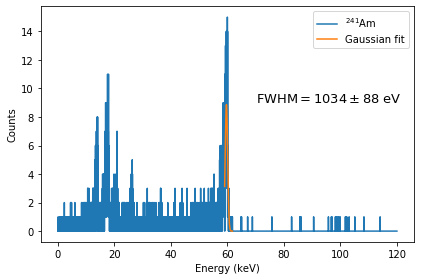

In [87]:
%%time
h119_Am241.plot_spectrum()

In [57]:
grade_mask = (time_data["GRADE"] == 0)

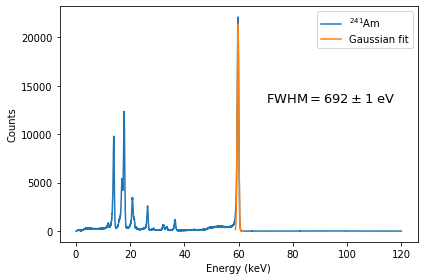

In [78]:
h119_Am241.gen_spectrum(save_data=False, misc_mask=~(tp_mask | mask) & grade_mask)
h119_Am241.plot_spectrum(save_plot=False)

In [562]:
clean_grade0_spectrum = h119_Am241.spectrum

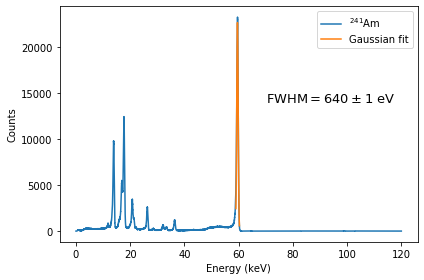

In [253]:
h119_Am241.plot_spectrum(spectrum=clean_grade0_spectrum, fit_below=50, fit_above=60)

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([   1,    2,    3, ..., 9997, 9998, 9999]),
 <a list of 9998 Patch objects>)

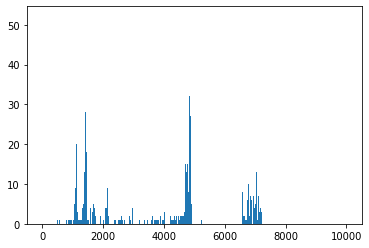

In [106]:
plt.hist(h119_Am241.raw_data_1d['PH'].loc[
    (h119_Am241.raw_data_1d['RAWX'] == 10) & (h119_Am241.raw_data_1d['RAWY'] == 10) & ~tp_mask &
    (h119_Am241.raw_data_1d['PH'] > 0)], bins=np.arange(1,10000))

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([   1,    2,    3, ..., 9997, 9998, 9999]),
 <a list of 9998 Patch objects>)

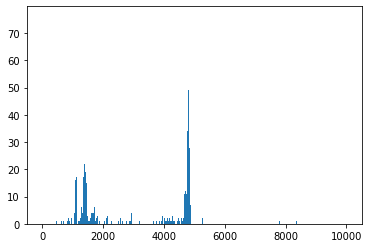

In [107]:
plt.hist(h119_Am241.raw_data_1d['PH'].loc[
    (h119_Am241.raw_data_1d['RAWX'] == 5) & (h119_Am241.raw_data_1d['RAWY'] == 5) & ~tp_mask &
    (h119_Am241.raw_data_1d['PH'] > 0)], bins=np.arange(1,10000))

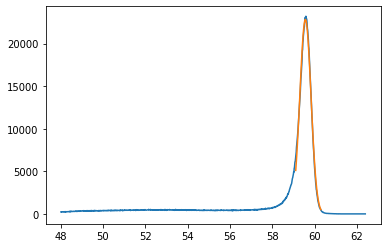

In [264]:
plt.plot(clean_grade0_spectrum[1][4000:5200], clean_grade0_spectrum[0][4000:5200])
plt.plot(clean_grade0_spectrum[1][4925:5025], line(clean_grade0_spectrum[1][4925:5025]))

In [248]:
clean_grade0_spectrum[0].argmax()

4965

In [37]:
from astropy.modeling import models, fitting

In [254]:
line_init = models.Gaussian1D(amplitude=22000, mean=59.7, stddev=0.8)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][4925:5025], clean_grade0_spectrum[0][4925:5025])

In [255]:
line.stddev * 2.355

0.6229666673634122

In [136]:
from scipy.interpolate import UnivariateSpline

In [228]:
spline = UnivariateSpline(clean_grade0_spectrum[1][4930:5000],
                          clean_grade0_spectrum[0][4930:5000] - clean_grade0_spectrum[0][4930:5000].max()/2, s=0.001)
roots = spline.roots() # find the roots

In [229]:
roots[1] - roots[0]

0.6155530018087916

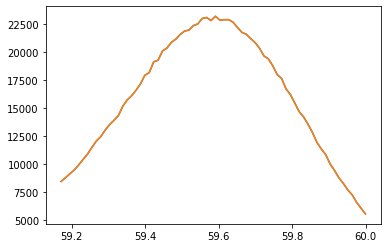

In [230]:
plt.plot(clean_grade0_spectrum[1][4930:5000], clean_grade0_spectrum[0][4930:5000])
plt.plot(clean_grade0_spectrum[1][4930:5000], spline(clean_grade0_spectrum[1][4930:5000]) + clean_grade0_spectrum[0].max()/2)

In [201]:
spline.roots()

array([59.25736209, 59.87291564, 59.99129095, 59.99687482])

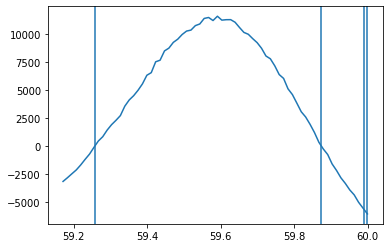

In [216]:
plt.plot(clean_grade0_spectrum[1][4930:5000], spline(clean_grade0_spectrum[1][4930:5000]))
for r in spline.roots():
    plt.axvline(r)

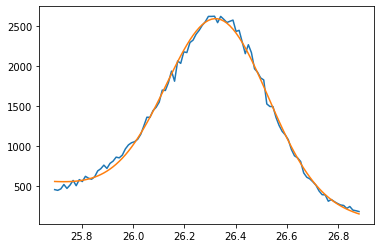

0.4677711677789126
2140


In [365]:
upper=2240
lower=2140

line_init = models.Gaussian1D(amplitude=3000, mean=26, stddev=0.8) + models.Linear1D(slope=-0.001, intercept=100)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))
plt.show()
print(line.stddev_0*2.355)

0.5157764570921799


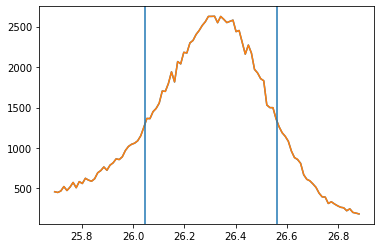

In [370]:
spline = UnivariateSpline(clean_grade0_spectrum[1][lower:upper],
                          clean_grade0_spectrum[0][lower:upper] - clean_grade0_spectrum[0][lower:upper].max()/2)
roots = spline.roots() # find the roots
print(roots[1] - roots[0])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], spline(clean_grade0_spectrum[1][lower:upper]) + clean_grade0_spectrum[0][lower:upper].max()/2)
plt.axvline(roots[0])
plt.axvline(roots[1])

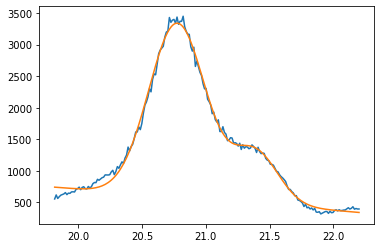

0.5256703873111515


In [362]:
upper=1850
lower=1650

line_init = models.Gaussian1D(amplitude=3500, mean=20.6, stddev=0.4) + models.Linear1D(slope=-0.0001, intercept=100) + \
    models.Gaussian1D(amplitude=1500, mean=21.5, stddev=0.4)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))
plt.show()
print(line.stddev_0*2.355)

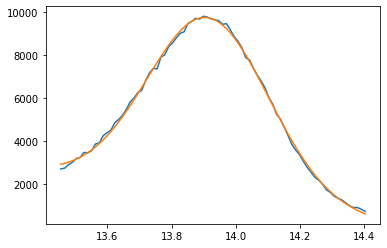

0.44469641579561453
Model: CompoundModel145
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=10000., mean=14., stddev=0.4)>

    [1]: <Linear1D(slope=-1000., intercept=15000.)>
Parameters:
       amplitude_0          mean_0      ...      slope_1          intercept_1   
    ----------------- ----------------- ... ------------------ -----------------
    8311.803083887024 13.91266074391862 ... -2275.321636545232 33082.88257067638
0.5073687088487286


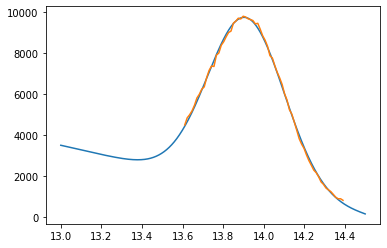

In [581]:
upper=1200
lower=1120

line_init = models.Gaussian1D(amplitude=10000, mean=14, stddev=0.4) + models.Linear1D(slope=-1000, intercept=15000)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))
plt.show()
print(line.stddev_0*2.355)
print(line)
xs = np.linspace(13, 14.5, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 14.0) < 0.4],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 14.0) < 0.4])
del xs, spline
print(roots[1] - roots[0])

In [357]:
line.stddev_2*2.355

0.4241348545477809

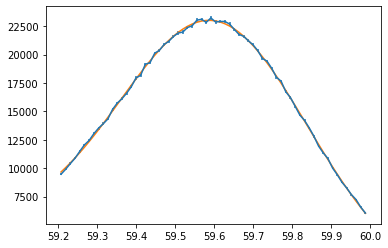

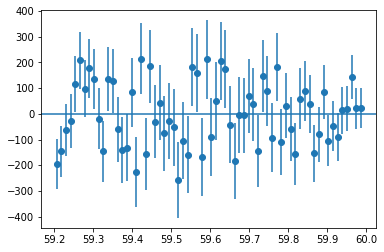

0.9719665333792206


In [563]:
upper=4995
lower=4930
lower=4933
upper=4999

line_init = models.Gaussian1D(amplitude=22000, mean=60, stddev=0.8) + models.Linear1D(slope=-0.001, intercept=100)
fit_line = fitting.LevMarLSQFitter()
line = fit_line(line_init, clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper])
plt.errorbar(clean_grade0_spectrum[1][lower:upper], clean_grade0_spectrum[0][lower:upper],
             yerr=np.sqrt(clean_grade0_spectrum[0][lower:upper]))
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]))
plt.show()

plt.errorbar(clean_grade0_spectrum[1][lower:upper],
             clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper]),
             yerr=np.sqrt(clean_grade0_spectrum[0][lower:upper]),
             fmt='o'
            )
plt.axhline(0)
plt.show()

chisq_red = np.sum(((clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper])) ** 2)/
                   clean_grade0_spectrum[0][lower:upper])/len(clean_grade0_spectrum[0][lower:upper] - 5)

print(chisq_red)

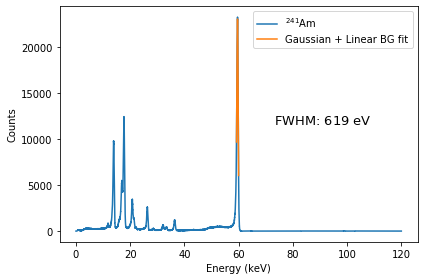

In [565]:
plt.plot(clean_grade0_spectrum[1], clean_grade0_spectrum[0], label='${}^{241}$Am')
plt.plot(clean_grade0_spectrum[1][lower:upper], line(clean_grade0_spectrum[1][lower:upper]), label='Gaussian + Linear BG fit')
plt.text(0.6, 0.5, f'FWHM: ${619:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)
plt.legend()
#plt.title('Full Frame Spectrum, Single Pixel Events Only')
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.savefig('energy_spectrum_floodAm241_5C_-500V_20190725_gain_grade0_GaussLinBG.pdf')

In [487]:
line

<CompoundModel115(amplitude_0=21115.3998748, mean_0=59.60044444, stddev_0=0.24368647, slope_1=-5104.3561973, intercept_1=306063.72795554)>

In [447]:
np.sqrt(fit_line.fit_info['cov_x'][2,2])*2.355*1000

0.05092735941567342

In [457]:
2.355*1000*np.sqrt(fit_line.fit_info['cov_x'][2,2]*((clean_grade0_spectrum[0][lower:upper] - line(clean_grade0_spectrum[1][lower:upper])) ** 2).sum()/(len(line(clean_grade0_spectrum[1][lower:upper])) - 5))

6.64907217768257

In [469]:
np.sqrt(fit_line.fit_info['param_cov'][2,2])*2.355*1000

6.64907217768257

In [483]:
def pixel_mask(x, y):
    return (h119_Am241.raw_data_1d['RAWX'] == x) & (h119_Am241.raw_data_1d['RAWY'] == y)

0.6191027046780135


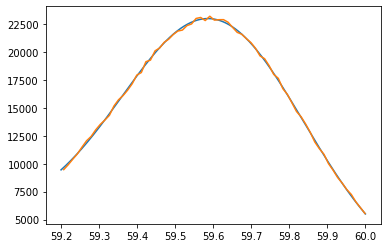

In [564]:
xs = np.linspace(59.2, 60, int(1e6))
spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
roots = spline.roots() # find the roots
plt.plot(xs, spline(xs)+line(xs).max()/2)
plt.plot(clean_grade0_spectrum[1][np.abs(clean_grade0_spectrum[1] - 59.6) < 0.4],
         clean_grade0_spectrum[0][np.abs(clean_grade0_spectrum[1] - 59.6) < 0.4])
del xs, spline
print(roots[1] - roots[0])

In [541]:
clean_grade0_spectrum[1][4999]

59.999000499999994

In [532]:
line

<CompoundModel125(amplitude_0=22534.64651141, mean_0=59.60100535, stddev_0=0.25769821, slope_1=-5350.04403953, intercept_1=319200.21696186)>

0.9575281432660526
0.619122078390383
1.0916815922928718
0.5109618004380465


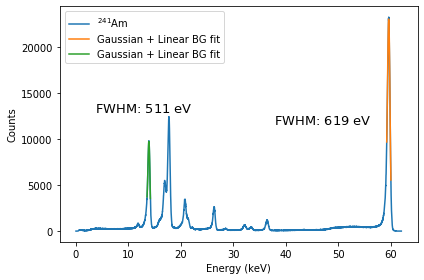

In [595]:
spec = clean_grade0_spectrum

lower=4933
upper=5000
fwhm, line = fit_line(spec, lower=lower, upper=upper, plot=False)

plt.plot(spec[1][(spec[1] < 62) & (spec[1] > 0)], spec[0][(spec[1] < 62) & (spec[1] > 0)], label='${}^{241}$Am')
plt.plot(spec[1][lower:upper], line(spec[1][lower:upper]), label='Gaussian + Linear BG fit')
plt.text(0.6, 0.5, f'FWHM: ${fwhm*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)

lower=1128
upper=1182
fwhm, line = fit_line(spec, lower=lower, upper=upper, energy=14, plot=False)
plt.plot(spec[1][lower:upper],
         line(spec[1][lower:upper]),
         label='Gaussian + Linear BG fit')
plt.text(0.1, 0.55, f'FWHM: ${fwhm*1000:.0f}$ eV', transform=plt.gca().transAxes, fontsize=13)


plt.legend()
plt.ylabel('Counts')
plt.xlabel('Energy (keV)')
plt.tight_layout()
plt.show()

In [591]:
def fit_line(spec, lower=4920, upper=5010, energy=59.6, plot=True):
    #upper=4995
    #lower=4930
    #lower=4920
    #upper=5010

    line_init = models.Gaussian1D(amplitude=np.max(spec[0]), mean=energy, stddev=0.3) + models.Linear1D(slope=-20, intercept=1000)
    fit_l = fitting.LevMarLSQFitter()
    line = fit_l(line_init, spec[1][lower:upper], spec[0][lower:upper])
    if plot:
        plt.errorbar(spec[1][lower:upper], spec[0][lower:upper],
             yerr=np.sqrt(spec[0][lower:upper]))
        plt.plot(spec[1][lower:upper], line(spec[1][lower:upper]))
        plt.show()

        plt.errorbar(spec[1][lower:upper],
             spec[0][lower:upper] - line(spec[1][lower:upper]),
             yerr=np.sqrt(spec[0][lower:upper]),
             fmt='o'
            )
        plt.axhline(0)
        plt.show()
    
    screened_cts = np.maximum(spec[0][lower:upper], 1)

    chisq_red = np.sum(((spec[0][lower:upper] - line(spec[1][lower:upper])) ** 2)/
                   screened_cts)/len(spec[0][lower:upper] - 5)

    print(chisq_red)
    xs = np.linspace(spec[1][lower], spec[1][upper], int(1e6))
    spline = UnivariateSpline(xs,
                          line(xs) - line(xs).max()/2)
    roots = spline.roots() # find the roots
    if plot:
        plt.plot(xs, spline(xs)+line(xs).max()/2)
        plt.plot(spec[1][lower:upper],
         spec[0][lower:upper])
        plt.show()
    del xs, spline
    print(roots[1] - roots[0])
    return roots[1] - roots[0], line
    #print(line)

(array([4872869.,   24952., 3436355.]),
 array([-1.,  0.,  1.,  2.]),
 <a list of 3 Patch objects>)

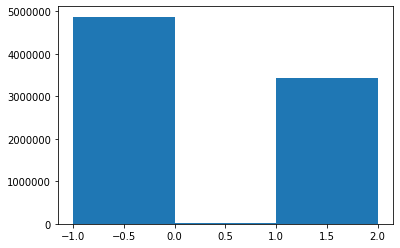

In [606]:
plt.hist(time_data['GRADE'].loc[pixel_mask(9, 18)], bins=3)

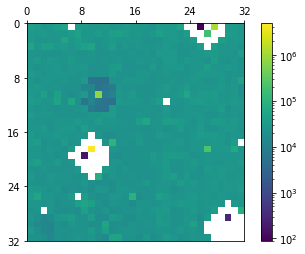

In [605]:
H, xedges, yedges = np.histogram2d(h119_Am241.raw_data_1d['RAWX'].loc[(time_data['GRADE'] == -1) & ~tp_mask],
                                   h119_Am241.raw_data_1d['RAWY'].loc[(time_data['GRADE'] == -1) & ~tp_mask],
           bins=32, range=[[0, 31], [0, 31]])

plt.imshow(H.T, norm=LogNorm(), extent=(0,32,32,0))
plt.gca().xaxis.tick_top()
plt.yticks(np.arange(0, 36, 8))
plt.xticks(np.arange(0, 36, 8))
plt.colorbar()

In [618]:
channel = h119_Am241.raw_data_1d.loc[
    (h119_Am241.raw_data_1d['RAWX'] == 5) & (h119_Am241.raw_data_1d['RAWY'] == 0) , 'PH']
times = time_data['RESET'].loc[(h119_Am241.raw_data_1d['RAWX'] == 5) & (h119_Am241.raw_data_1d['RAWY'] == 0)]

(0, 5000)

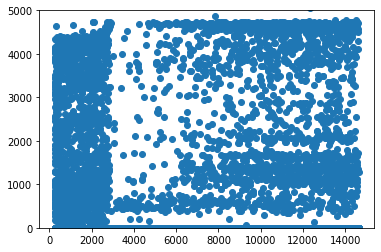

In [621]:
plt.scatter(times, channel)
plt.ylim(0,5000)

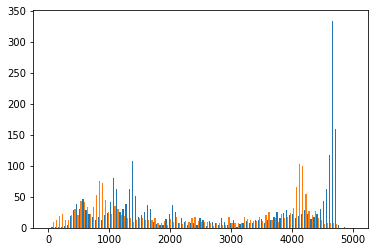

In [633]:
_= plt.hist([channel.loc[(time_data["RESET"] > (200*14.7456))],
            channel.loc[(time_data["RESET"] < (200*14.7456))]], bins=np.linspace(1,5001, 100))